# End-to-end multi-class dog breed classification

This notebook buils an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identify the breed of a dog from a given image of a dog.

## 2. Data

The dta we are using is from Kaggl'es dog breed idenfication competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We are dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 differnt classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set ( these images have no labels, because we will want to predict them).

In [2]:
# Unzip the uploaded data into Google drive
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we are using a GPU

In [3]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "availabe" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.2.0
TF Hub version: 0.8.0
GPU availabe


### Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we will be doing first. Turning our images into Tensor(numerical representation).

Let's start by accessing our data and checking out the labels.

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6782c77720149b1b1d96d3494363efec  scottish_deerhound
freq                                   1                 126


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

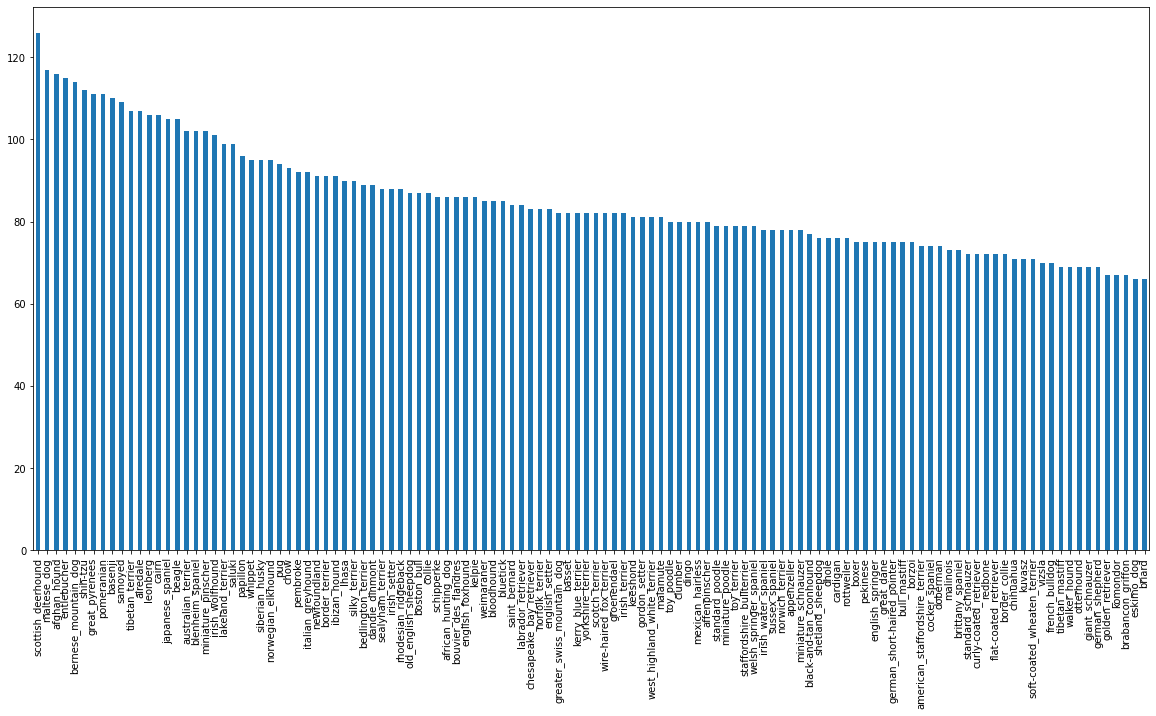

In [5]:
# How many images are there of each breeds ?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

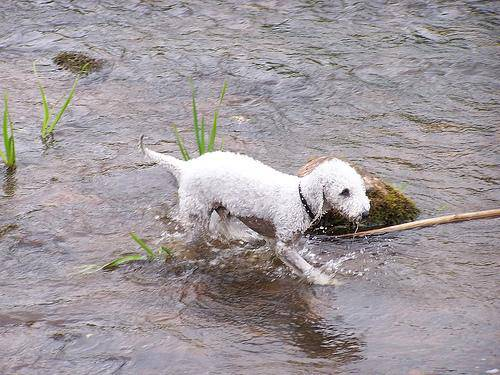

In [7]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [8]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [9]:
# Create pathnames form image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whetehr number of fileames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!! Proceed.")
else:
  print("Filenames do not mathc the actual amount of files, check the target dictionary.")

Filenames match actual amount of files!! Proceed.


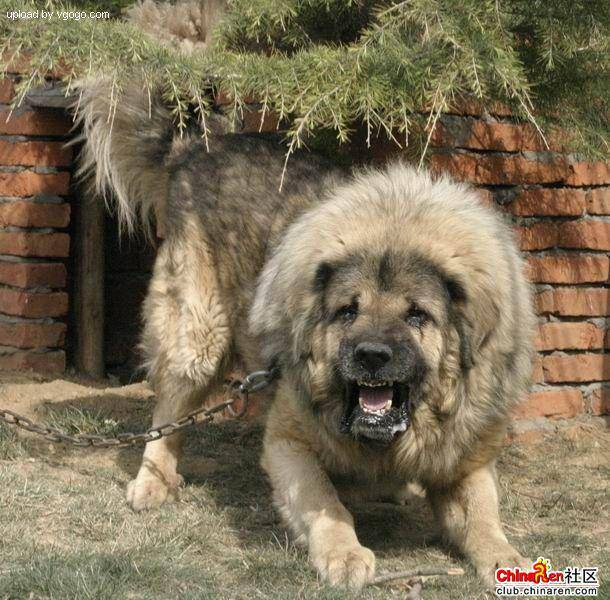

In [11]:
# One more check
Image(filenames[9000])

In [12]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we have now got our training image filepaths in a list, let's prepare our labels.

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [16]:
# Find tht unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [17]:
# Turn a singe label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [19]:
len(boolean_labels)

10222

In [20]:
# Example: Turning boolean array into intergers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) #index where labels occur in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [21]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Sicne the dataset from kaggle doesn't come with a validation set, we are going to create our own.

In [22]:
# Serup x and y variables
x = filenames
y = boolean_labels

In [23]:
len(filenames)

10222

We are going to start off experimenting with ~1000 images and increase as needed.

In [24]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [25]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [26]:
# Let's have a geez at the training data
x_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing Images (turning images into Tensor)

To preprocess our images into Tensors we are going to write a function whcih does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn `image` (a jpg) into Tensors
4. Rezise the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we don, let's see what importing an image looks like.

In [27]:
# Convert image to an NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image.max(), image.min()

(255, 0)

In [29]:
# Turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we have seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn `image` (a jpg) into Tensors
4. Normalize our image (convert color channel vlaues fom 0-255 to 0-1)
5. Rezise the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [30]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired values (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches ?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is batch size) images at a time (you cna manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [31]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path and the associated label, processes 
  image and returns a type of (image, labe).
  """
  image = process_image(image_path)
  return image, label

In [32]:
# Demo of the above
(process_image(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`x` and `y`) into batches!

In [33]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False,
                        test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels 
  if test_data:
    print("Creating test data bathces...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x)) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating traning data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                              tf.constant(y)))
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling image
    data = data.shuffle(buffer_size=len(x))

    #Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [34]:
# Creatng training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating traning data batches...
Creating validation data batches...


In [35]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [36]:
train_data, val_data

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>)

## Visualising Data batches

Our data is now in batches, however, these can be a little hard to understand/comprehend. let's visualize them

In [37]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot fo 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    # plt.axis("off")

In [38]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.7133822 , 0.57294524, 0.36274964],
          [0.68954235, 0.5314998 , 0.33202696],
          [0.78673697, 0.593472  , 0.41309378],
          ...,
          [0.5003693 , 0.34161565, 0.17008196],
          [0.5563676 , 0.42203337, 0.24595477],
          [0.56941164, 0.4372686 , 0.2778499 ]],
 
         [[0.5659479 , 0.383061  , 0.19208583],
          [0.47963932, 0.2767389 , 0.09400667],
          [0.46178734, 0.23286575, 0.06731076],
          ...,
          [0.4899345 , 0.33088428, 0.15948187],
          [0.5740429 , 0.42857713, 0.25620902],
          [0.62226385, 0.4901208 , 0.3307021 ]],
 
         [[0.6824056 , 0.42486778, 0.26939425],
          [0.5684255 , 0.29434562, 0.14404495],
          [0.55494064, 0.24780655, 0.11783917],
          ...,
          [0.49648437, 0.3289289 , 0.16087912],
          [0.55918944, 0.41322577, 0.24100734],
          [0.5868815 , 0.4547385 , 0.2953198 ]],
 
         ...,
 
         [[0.6202628 , 0.5928118 , 0.5300667 ],
          [0.67920

In [39]:
len(train_images), len(train_labels)

(32, 32)

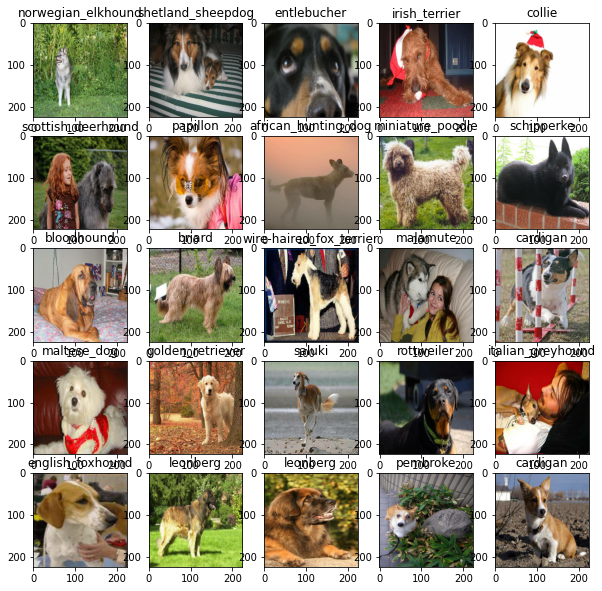

In [40]:
# Now let's visaulise the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

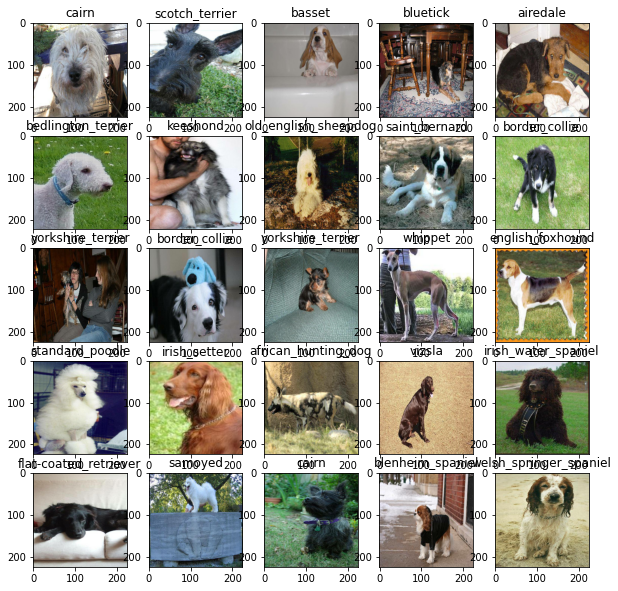

In [41]:
# Now let's visualise our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shapre (our images shape, in the form of Tensors) to our model.
* The outpot shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to see.

* The URL of the model we want to us from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [42]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output share of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now ew have got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning mode1

Knowing this, Let's create a function which:
* Takes the input shape, output shape and the model we have chosen as parameters.
* Define the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it will be getting).
* Returns the model.

ALl of these steps can be found here: https://www.tensorflow.org/guide/keras/overview


In [43]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building the model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                               activation="softmax")]) # Layer 2 (output layer)
  
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [44]:
model = create_model()
model.summary()

Building the model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We will create two callbacks, one for TensorBaord which helps track our model progres and another for early stopping which prevents our model from trnaing for too long.

### TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function ( we will do this after model trainig).


In [45]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [46]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs/",
              # Make it so the logs get tracked whenever we run an experiment
              datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [47]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [48]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}


In [49]:
# Check to make sure we are still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function o nour model passing it the training data, validation data, number of epochs to trian for (`NUM_EPOCHS`) and the callback we would like to see
* Return the model

In [50]:
# Build a function tot train and return a trained model
def train_model():
  """
  Trains a given mode and returns the trained version.
  """
  # Create a mode
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model


In [51]:
# # Fit the model to the data
# model = train_model()

#### Checking the TensorBoard logs

The TensorBoard magic function
 (`%tensorboard`) will access the logs directory we created earlier and visualize its contents

In [52]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

Output hidden; open in https://colab.research.google.com to view.

## Making and evaluating predictions using a trained model

In [53]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 90s 13s/step


array([[0.00445603, 0.03865662, 0.00124128, ..., 0.08737787, 0.00146282,
        0.00210903],
       [0.00164308, 0.00089632, 0.00392973, ..., 0.16036862, 0.00736232,
        0.00384476],
       [0.00071735, 0.02665294, 0.0051162 , ..., 0.00124528, 0.00101071,
        0.00038448],
       ...,
       [0.00262688, 0.00214028, 0.00140237, ..., 0.01194541, 0.02301822,
        0.00063599],
       [0.00584024, 0.00107182, 0.00281691, ..., 0.01675296, 0.00568716,
        0.0007323 ],
       [0.00251938, 0.01554081, 0.00247218, ..., 0.0003352 , 0.00173427,
        0.00260533]], dtype=float32)

In [54]:
predictions.shape

(200, 120)

In [55]:
np.sum(predictions)

200.0

In [56]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[0.00461203 0.00375671 0.01161976 0.0016316  0.00361568 0.00450312
 0.00924448 0.00378879 0.0023244  0.01515841 0.00391256 0.00037882
 0.11999628 0.00039886 0.00321588 0.01477407 0.08934654 0.00029211
 0.00101525 0.00033988 0.0054965  0.00181059 0.04786311 0.00177923
 0.01021749 0.00604841 0.01253774 0.00642732 0.00174272 0.00433188
 0.00767641 0.00196708 0.005072   0.01435526 0.02644696 0.00983135
 0.00334045 0.00227189 0.01836836 0.00183323 0.00786392 0.00105423
 0.00407567 0.00333716 0.00209774 0.00133956 0.00337418 0.00186403
 0.00058206 0.04448424 0.00729173 0.01048114 0.00042716 0.00369619
 0.03486281 0.0018451  0.00025356 0.00624195 0.03090584 0.00074511
 0.00674444 0.00091082 0.00089376 0.00363939 0.01525749 0.00622158
 0.00267565 0.00237861 0.00418187 0.01092113 0.00280951 0.0017504
 0.00170014 0.00647113 0.00245601 0.01438949 0.00202036 0.00992229
 0.01130784 0.00138825 0.00560396 0.00168834 0.00028957 0.01114035
 0.00356435 0.00194179 0.00100948 0.00170689 0.0124082  0.00225

In [57]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great but we want to be able to di it at scale.

And it would be even better if we could see the image the predictions is being made on!

**Notes:** Prediction probabilities are also known as confidence levels.

In [58]:
# Turns prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilties 
pred_label = get_pred_label(predictions[90])
pred_label

'border_collie'

Now since our validation data is still in a batch dataset, we will have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [59]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in val_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [60]:
get_pred_label(val_labels[0])

'affenpinscher'

Now we've got aways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and as an array of images and as integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predcited probability, the truth label and the target image in a single plot.

In [61]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and images for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probabiltiy of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

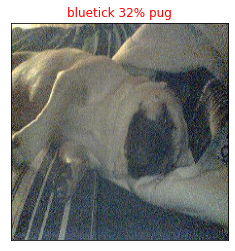

In [62]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=80)

Now we have got oen function to visualise our models top prediction, let's make another to view our models top 10 precitions.

The function will:
* Take an input of predcition probabilities array and a ground truth array and an integer
* Find the prediciton using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [63]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for smaple n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

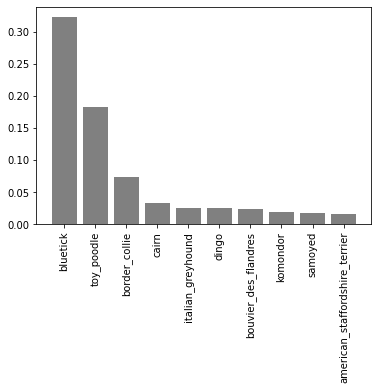

In [64]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=80)

Now we've got some functions to help us visualise our predictions and evalute our model, let's check out a few.

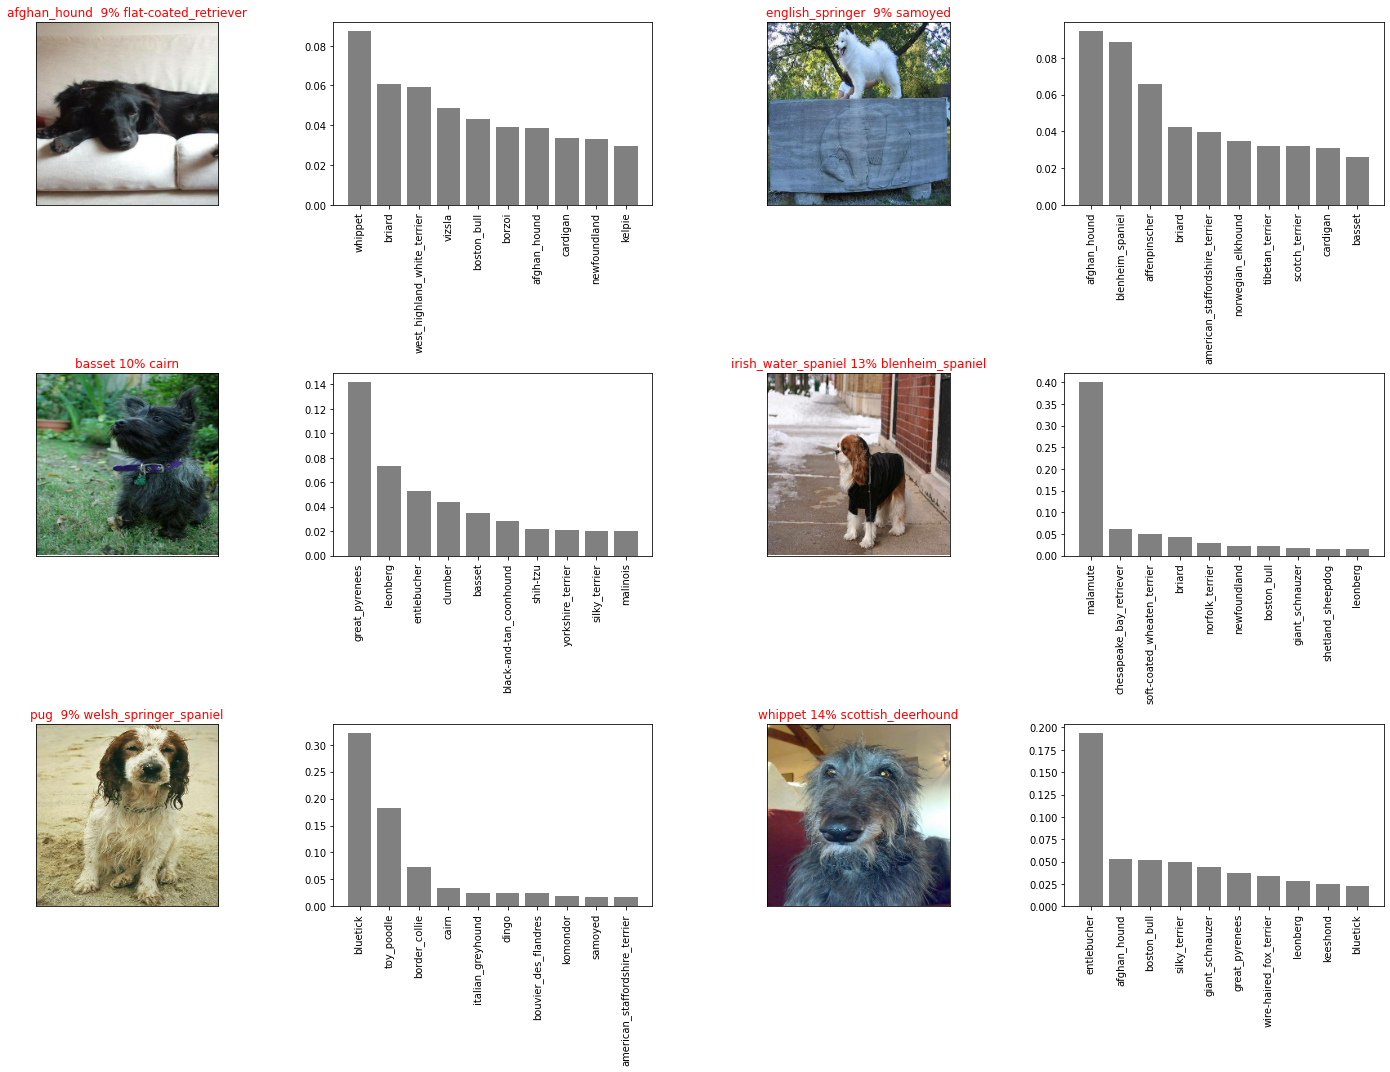

In [65]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i*i_multiplier)
plt.tight_layout(h_pad=1.0)  
plt.show()

**Challege:** How would you create a confusion matrix with our model predictiosn and true labels?

## Saving and reloading a trained model

In [66]:
# Create a function to save a model:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [67]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")

  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

Now we have got functions to save and load a trained model, let's make sure they work

In [68]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200718-11581595073484-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200718-11581595073484-1000-images-mobilenetv2-Adam.h5'

In [69]:
# Load a trained model
loaded_1000_image_model = load_model("/content/drive/My Drive/Dog Vision/models/20200716-19011594926119-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: /content/drive/My Drive/Dog Vision/models/20200716-19011594926119-1000-images-mobilenetv2-Adam.h5


In [70]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 105ms/step - loss: 5.6127 - accuracy: 0.0100


[5.612726211547852, 0.009999999776482582]

In [71]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 108ms/step - loss: 1.3092 - accuracy: 0.6550


[1.3091620206832886, 0.6549999713897705]

## Training a big dog model (on the full data)

In [72]:
len(x), len(y)

(10222, 10222)

In [73]:
x[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [74]:
len(x_train)

800

In [75]:
# Create a data batch with the full data set
full_data = create_data_batches(x, y)

Creating traning data batches...


In [76]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [77]:
# Create a model for full model
full_model = create_model()

Building the model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


**Note:** Running the cell below will take a little while (maybe upto 30 minutes for the first epoc) because the GPU we are using in the runtime has to load all of the images into memory.

In [78]:
# # Create full model callbacks
# full_model_tensorboard = create_tensorboard_callback()
# # No validation set when training on all the data, so we can't monitor validation accuracy
# full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
#                                                              patience=3)

# # Fit the full model to the full data
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [79]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200718-11581595073500-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200718-11581595073500-full-image-set-mobilenetv2-Adam.h5'

In [108]:
# Load the full model
loaded_full_model = load_model("/content/drive/My Drive/Dog Vision/models/20200716-20551594932903-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: /content/drive/My Drive/Dog Vision/models/20200716-20551594932903-full-image-set-mobilenetv2-Adam.h5


## Making prediction on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we will have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we will:
* Get the test image filenames
* Convert the filenaems into test data batches using `create_data_batches()` and setting the `test_data` parameters to `True` (since the test data doesn't have labels).
* Make a prediction array by passing the test batches into the `predict()` method called on our model.

In [81]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/e90b4707267cec5bcd2dbe4cbb68a070.jpg',
 'drive/My Drive/Dog Vision/test/ed8e5c431d6539db02614ddc1f35ce10.jpg',
 'drive/My Drive/Dog Vision/test/ea5a2c10729ab1ffec74c0aabce02b52.jpg',
 'drive/My Drive/Dog Vision/test/eeffe08e577ad8dda81bbfe12bf8faea.jpg',
 'drive/My Drive/Dog Vision/test/e864f3fc5d19aec4b7a5aa547b359c57.jpg',
 'drive/My Drive/Dog Vision/test/f0ee3d22666302ec27338aa29f34c72f.jpg',
 'drive/My Drive/Dog Vision/test/ec390da7ac7297a2477e3b838e7c502d.jpg',
 'drive/My Drive/Dog Vision/test/e8232c9a79f0e77e9b4c5fca60682d41.jpg',
 'drive/My Drive/Dog Vision/test/e9d385cf5f217ce1378bee8c0a89db62.jpg',
 'drive/My Drive/Dog Vision/test/f4eb6450497df847ef1012d61d869007.jpg']

In [82]:
len(test_filenames)

10357

In [83]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data bathces...


In [84]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an hour).

In [85]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

KeyboardInterrupt: ignored

In [ ]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
test_predictions[:10]

In [ ]:
test_predictions.shape

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle smaple submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get that data in this format, we will:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID coumn by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
["id"] + list(unique_breeds)

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
# Save our predictions DataFrame to CSV
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we will:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we se the `test_data` parameters to `True`.
* Pass the custom image data batch to our model's `prediction()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [109]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/CustomData/"
custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]

In [110]:
custom_image_path

['drive/My Drive/Dog Vision/CustomData/4B3E32BA-5E63-4DF6-867A-9ABBB2AB1394.jpg',
 'drive/My Drive/Dog Vision/CustomData/4d3bd7de-0006-4002-a80b-481be6e55962.jpg']

In [111]:
# Turn custom images into batch dataset
custom_data = create_data_batches(custom_image_path, test_data=True)
custom_data

Creating test data bathces...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [112]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [113]:
custom_preds.shape

(2, 120)

In [114]:
# Get custom image prediction labels
custom_preds_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_preds_labels

['kuvasz', 'golden_retriever']

In [115]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Lopp through unbatched data
for images in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

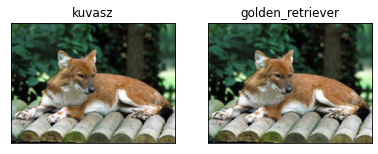

In [116]:
# Check custom image preditions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_labels[i])
  plt.imshow(image)